In [107]:
import sys
sys.path.insert(1,'../functions/')
import torch
from torch import nn
import numpy as np
import data_sim
import matplotlib.pyplot as plt
import xarray as xr
import copy
import pandas as pd
from torch.utils.data import Dataset, DataLoader
#from slab_spike_model_constructor import *
from full_slab_spike_model_constructor import *
from training_func import *

In [108]:
torch.cuda.is_available()

False

In [3]:
# G_21 = xr.open_dataset("../../../Desktop/CURRENT_RESEARCH/Latent_mixture/data/G_21_subset_imputed.nc")
# G_21 = G_21.to_array().values.squeeze(0)
# G_21.shape

In [4]:
# read the 
unrel_subj = pd.read_table("../../../Desktop/CURRENT_RESEARCH/Latent_mixture/data/ABCD_20220428.updated.nodups.curated_pcair_unrels.txt", header = None)
snp_prune = pd.read_table("../../../Desktop/CURRENT_RESEARCH/Latent_mixture/data/ABCD_20220428.updated.nodups.curated_prunned.snps", header = None)


In [5]:
from pandas_plink import read_plink1_bin, Chunk
ABCD_full = read_plink1_bin("../../../Desktop/CURRENT_RESEARCH/Latent_mixture/data/ABCD_20220428.updated.nodups.curated.bed",
                      chunk=Chunk(nsamples=100, nvariants=None))
ABCD_full = ABCD_full.where(ABCD_full.sample.isin(unrel_subj.to_numpy().squeeze(1)), drop=True)
#ABCD_full.where(ABCD_full.variant.isin(snp_prune.to_numpy().squeeze(1)), drop=True)
freq_snp = ABCD_full.mean(axis = 0)/2
sd_snp = np.sqrt(2*freq_snp*(1-freq_snp))
# a subset that have variability in the SNPs
ABCD_sub = ABCD_full[:,~sd_snp.isin(0)]
freq_snp = ABCD_sub.mean(axis = 0)/2
sd_snp = np.sqrt(2*freq_snp*(1-freq_snp))
ABCD_sub = (ABCD_sub-2*freq_snp)/sd_snp
ABCD_sub.persist()


Mapping files: 100%|██████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.43it/s]


<xarray.DataArray 'genotype' (sample: 8005, variant: 506989)>
dask.array<truediv, shape=(8005, 506989), dtype=float32, chunksize=(80, 506989), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * sample   (sample) object 'NDAR_INV003RTV85' ... 'NDAR_INVZZZP87KR'
  * variant  (variant) <U13 'variant0' 'variant1' ... 'variant516597'
    fid      (sample) object 'NDAR_INV003RTV85' ... 'NDAR_INVZZZP87KR'
    iid      (sample) object 'NDAR_INV003RTV85' ... 'NDAR_INVZZZP87KR'
    father   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    mother   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    ...       ...
    chrom    (variant) object '1' '1' '1' '1' '1' ... '26' '26' '26' '26' '26'
    snp      (variant) object 'rs3131972' 'rs3131962' ... 'chr26:16526'
    cm       (variant) float64 0.008 0.008 0.009 0.009 0.009 ... 0.0 0.0 0.0 0.0
    pos      (variant) int32 752721 756604 779322 795222 ... 16356 16362 16526
    a0       (variant) object 'A' 'A' 'G' 'G' 'G' 'G' ... 'T' 'C' 'C' 'C' 'A'
    a1       (variant) object 'G' 'G' 'A' 'C' 'A' 'A' ... 'C' 'T' 'T' 'T' 'G'

In [6]:
ABCD_sub =  ABCD_sub.values
ABCD_sub[np.isnan(ABCD_sub)]=0

In [7]:
ABCD_sub.shape

(8005, 506989)

In [109]:
real_data_index = False
max_n_p = False
n = 100
p = 1000
p_causal = 10
batch_size = 20
tobit = True
r_batch = batch_size/n
device = 'cpu'
if real_data_index:
    if not max_n_p:
        np.random.seed(seed = None)
        p_max = ABCD_sub.shape[1]
        n_max = ABCD_sub.shape[0]
        SNP_index = np.random.choice(p_max,size = p, replace = False)
        subject_index =  np.random.choice(n_max,size = n, replace = False)
        ABCD_sub_sub = ABCD_sub[np.ix_(subject_index, SNP_index)]
        print(ABCD_sub_sub.shape)
        Xs = [ABCD_sub_sub]
    else:
        Xs = [ABCD_sub]
    n = Xs[0].shape[0]
    p = Xs[0].shape[1]
else:
    Xs = None
print(r_batch)

0.2


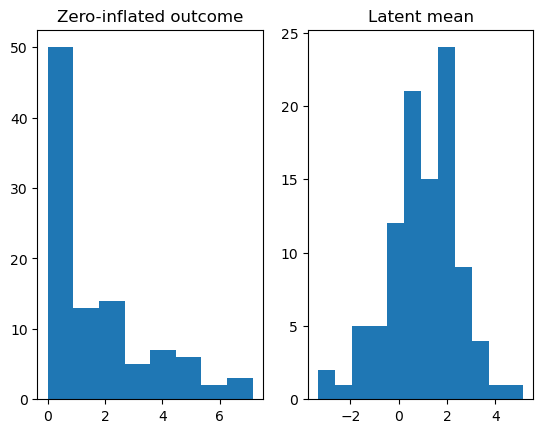

------------------------------------
genetic variance is 2.087403184746112
total variance is6.958010615820374
heritability is 0.29999999999999993
------------------------------------


In [110]:
rho = 0.6
var = 1
n_matrix = 1
h = 0.3
beta_bias = 1
sim_class = data_sim.sim_tobit_data(n = n, p = p, p_causal = p_causal, rho = rho, var = var, n_matrix = n_matrix,h = h, bias = beta_bias, Xs = Xs, scale_lambda =None)
z, X, Xs, latent_mean, var_genetic, var_total, true_beta, y_star = sim_class.gen_data(seed = None)
data_sim.show_sim(z, latent_mean, var_total)
if tobit:
    y_star = z

In [111]:
exact_lh = True
sim_data = Sim_Dataset(X,y_star, device = device)
sim_data_loader = DataLoader(sim_data, batch_size = batch_size)
model = linear_slab_spike(p = p, n_total = n, init_pi_local = 0.5, init_pi_global = 0.1, init_beta_var =0.1, init_noise_var = 1,
                         gumbel_softmax_temp = 1, gumbel_softmax_hard = False, 
                          a1= 0.1, a2=1, init_a3= 0.1, init_a4 = 0.1,
                          b1 = 0.1, b2 = 0.1, init_b3 = 1.1, init_b4 = 1.1, n_E = 1
                          , prior_sparsity = True, prior_sparsity_beta = False,exact_lh = exact_lh,tobit = tobit, device = device
                         ).double().to(device)
optimizer = torch.optim.Adam(
    [{'params': model.beta_mu},
     {'params': model.beta_log_var},
     {'params': model.logit_pi_local, 'lr': 0.01},
     {'params': model.log_a3},
     {'params': model.log_a4},
     {'params': model.log_b3},
     {'params': model.log_b4},
     {'params': model.bias},
     {'params': model.logit_pi_global, 'lr':0.01},
     {'params': model.beta_log_var_prior},
     {'params': model.log_var_noise},
    ],
    lr = 0.01)

At iteration 0, the loss is 2302.714046832127
At iteration 1000, the loss is 126.94858366498048


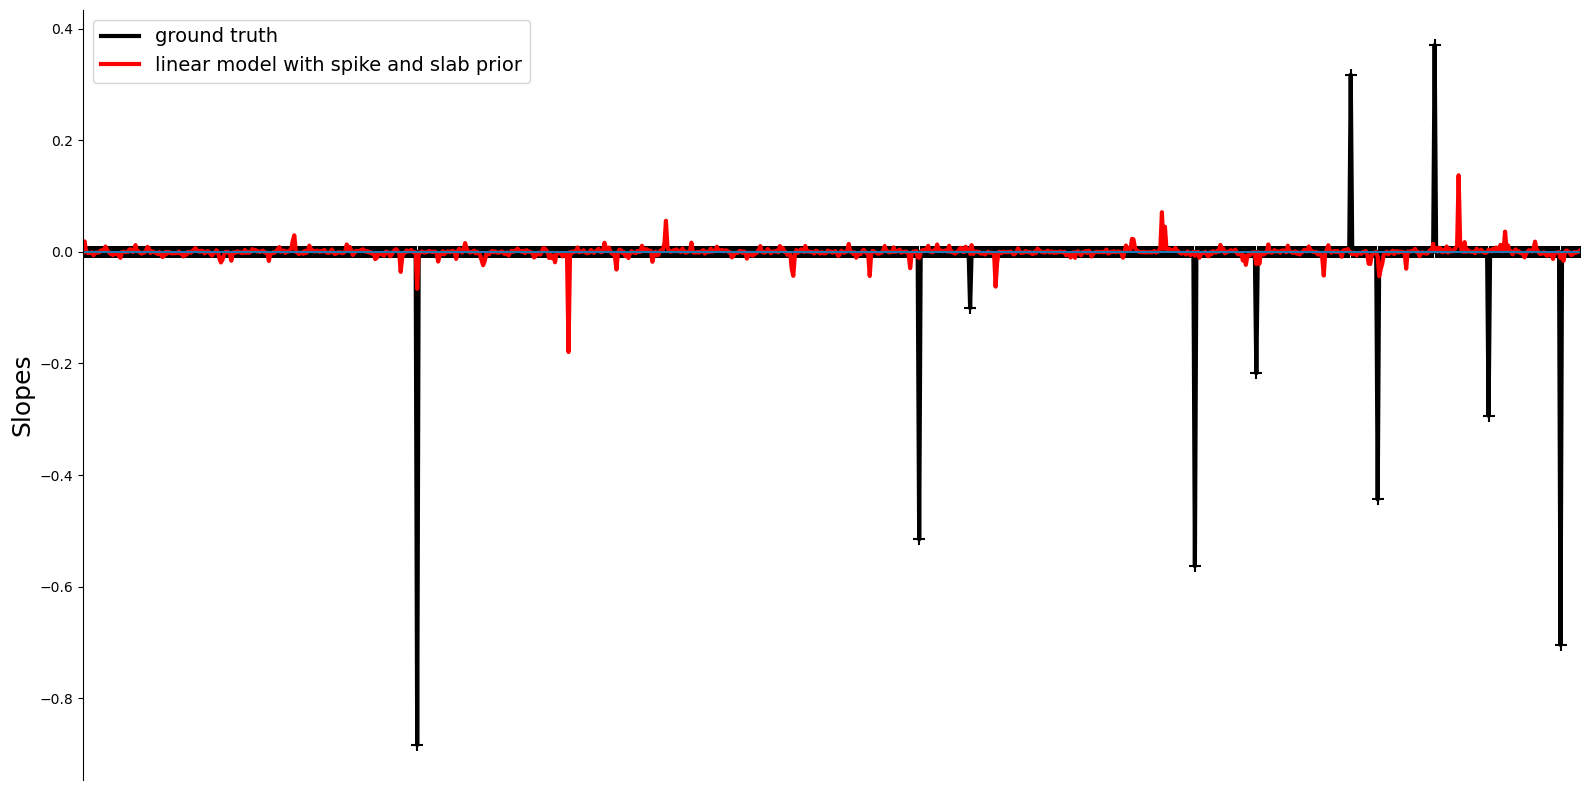

In [112]:
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)
t = 100 #number of moving averages
patience = 200# patience
_, result_dict = train_and_infer(model = model, optimizer = optimizer, sim_data_loader = sim_data_loader, lr_scheduler = lr_scheduler, t = t, patience = patience,X = X, plot = True, true_beta = true_beta, verbose = True)

In [113]:
result_dict

{'mean_h_est': [0.3245469004582003],
 'h_est_upper': [0.6392367515101337],
 'h_est_lower': [0.07472211440166167],
 'mean_var_genetic': [2.6748578256183135],
 'noise_var': [7.090432112937025],
 'global_pi': [0.025175458339156045],
 'global_pi_upper': [0.06077212620733714],
 'global_pi_lower': [0.0047580292320476255]}

In [114]:
p_causal/p

0.01

In [115]:
pi_VI = torch.sigmoid(model.logit_pi_local).detach().numpy()

In [116]:
# torch.sum(torch.sigmoid(model.logit_pi_local)>0.9)/p
print(torch.max(torch.sigmoid(model.logit_pi_local)))
print(torch.min(torch.sigmoid(model.logit_pi_local)))
# torch.min(model.beta_mu)
# torch.max(model.beta_mu)
torch.exp(model.beta_log_var)
print(torch.mean(torch.exp(model.beta_log_var)))

tensor(0.2851, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.0124, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.0434, dtype=torch.float64, grad_fn=<MeanBackward0>)


In [117]:
# c = torch.exp(best_model.log_c).detach().numpy()
# d = torch.exp(best_model.log_d).detach().numpy()
# # c = 10
# # d = 10
# print(c)
# print(d)
# posterior = np.random.beta(c,d,size = (5000,))
# np.median(posterior)
# print(np.quantile(posterior, q = 0.025))
# print(np.quantile(posterior, q = 0.975))
# plt.hist(posterior)
# plt.show()

# MCMC algorithm

In [118]:
from mcmc_linear import experiment, linear_mcmc_model, tobit_mcmc_model
import jax.numpy as jnp

def comparison_plot(est, true):
    p = len(true)
    fig = plt.figure(figsize=(16,8), facecolor='white')
    ax = fig.add_subplot(1,1,1)
    ax.plot(np.arange(p), true, \
           linewidth = 3, color = "black", label = "ground truth")
    ax.scatter(np.arange(p), true, \
           s = 70, marker = '+', color = "black")
    ax.plot(np.arange(p),  est, \
               linewidth = 3, color = "red", \
               label = "linear model with spike and slab prior")
    ax.set_xlim([0,p-1])
    ax.set_ylabel("Slopes", fontsize=18)
    ax.hlines(0,0,p-1)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.legend(prop={'size':14})
    fig.set_tight_layout(True)
    plt.show()




In [119]:
if tobit:
    model_mcmc = tobit_mcmc_model
else:
    model_mcmc = linear_mcmc_model
exp = experiment(model_mcmc, y_star.numpy(), X.numpy())
exp.train(step_size =1,verbose = True)
heritability, genetic_var, data_var = exp.cal_heritability()

sample: 100%|█| 1200/1200 [00:23<00:00, 51.08it/s, 127 steps of size 1.37e-01. acc


In [120]:
posterior = exp.mcmc.get_samples()
beta = posterior["beta"]* posterior["delta"]
g_var = (beta @ jnp.transpose(X.numpy()) ).var(axis = 1)
dat_var = posterior["var_error"]
heritability = g_var/(dat_var+g_var)
print('point estimate of heritability: '+ str(np.mean(heritability)))
print('lower bound of heritability: '+ str(np.quantile(heritability, 0.025)))
print('upper bound of heritability: '+ str(np.quantile(heritability, 0.975)))
print('point estimate of p_causal: '+ str(np.mean(exp.mcmc.get_samples()['pi'], axis = 0)))
print('lower bound of p_causal: '+ str(np.quantile(exp.mcmc.get_samples()['pi'], 0.025)))
print('upper bound of p_causal: '+ str(np.quantile(exp.mcmc.get_samples()['pi'], 0.975)))

point estimate of heritability: 0.048263907
lower bound of heritability: 0.0
upper bound of heritability: 0.275120498239994
point estimate of p_causal: 0.0019766877
lower bound of p_causal: 3.228484121109432e-06
upper bound of p_causal: 0.009985974361188709


0.0038891837
0.0
0.102000006
0.001


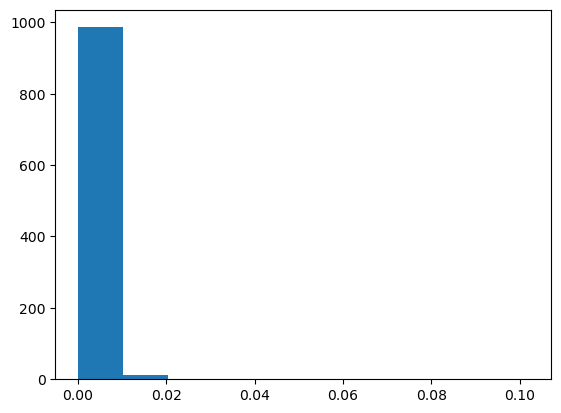

In [121]:
pi_mcmc = np.mean(posterior["delta"], axis = 0)
plt.hist(pi_mcmc)
print(np.std(pi_mcmc))
print(np.min(pi_mcmc))
print(np.max(pi_mcmc))
print(np.median(pi_mcmc))

0.01690485166360111
0.01240696010497644
0.28513547545968654
0.016061687437057277


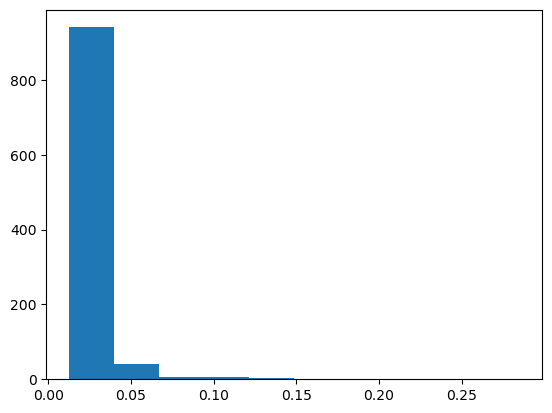

In [122]:
plt.hist(pi_VI)
print(np.std(pi_VI))
print(np.min(pi_VI))
print(np.max(pi_VI))
print(np.median(pi_VI))

In [123]:
print(np.where(pi_VI>0.3))
print(pi_VI[np.where(pi_mcmc>0.3)])

(array([], dtype=int64),)
[]


In [124]:
pi_mcmc[np.where(pi_mcmc>0.3)]

Array([], dtype=float32)

In [125]:
beta_mcmc = np.mean(posterior["beta"], axis = 0)
beta_VI = model.beta_mu.detach().numpy()

In [126]:
print(beta_VI[np.where(beta_mcmc>0.5)])
print(beta_mcmc[np.where(beta_mcmc>0.5)])
print(pi_VI[np.where(beta_mcmc>0.5)])
print(pi_mcmc[np.where(beta_mcmc>0.5)])

[]
[]
[]
[]


In [127]:
print(beta_VI[np.where(beta_VI>0.5)])
print(beta_mcmc[np.where(beta_VI>0.5)])

[]
[]


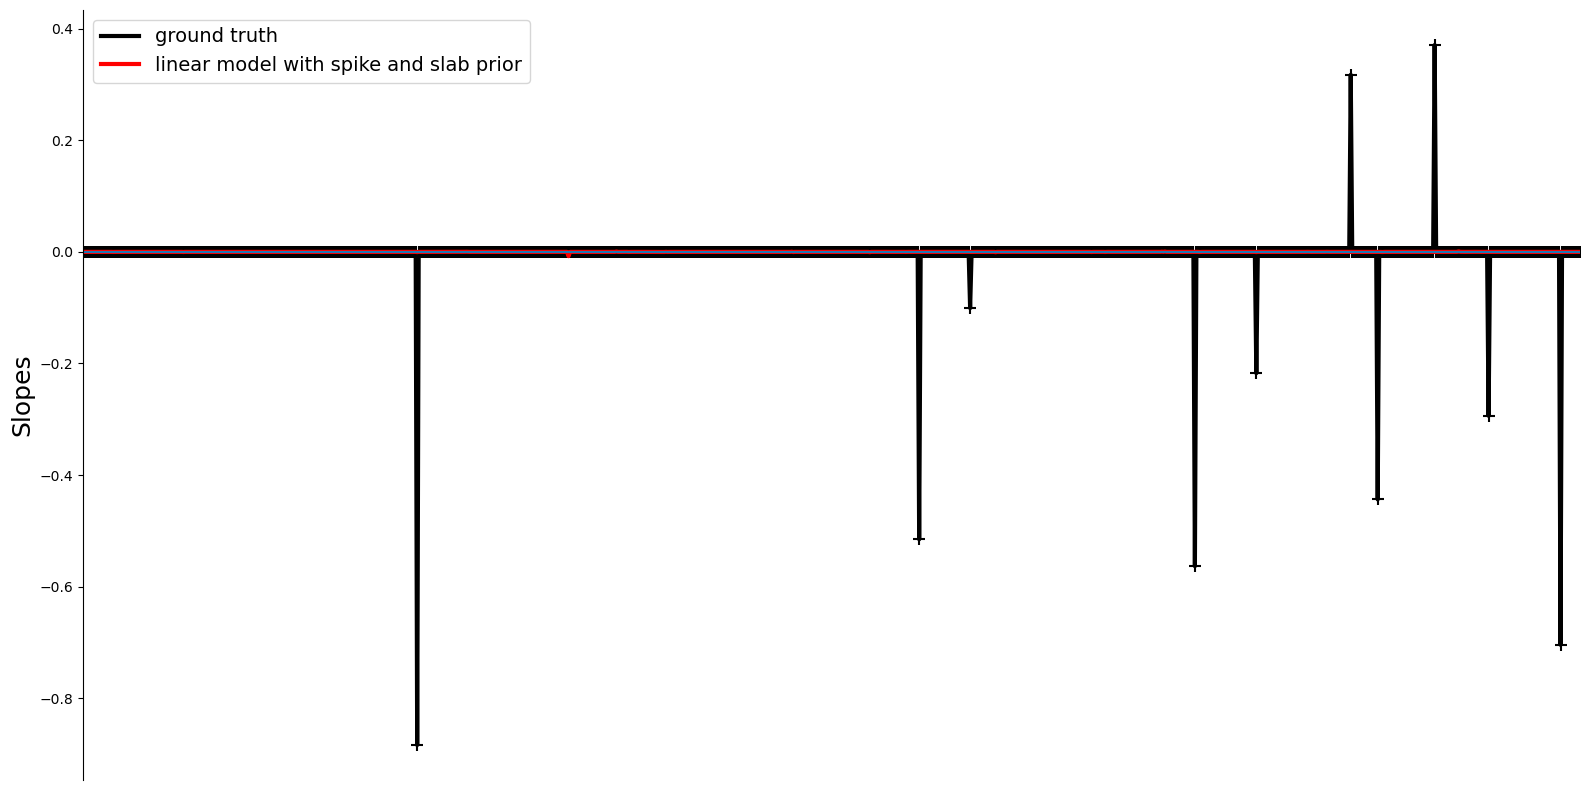

In [128]:
comparison_plot(beta_mcmc*pi_mcmc, true_beta)

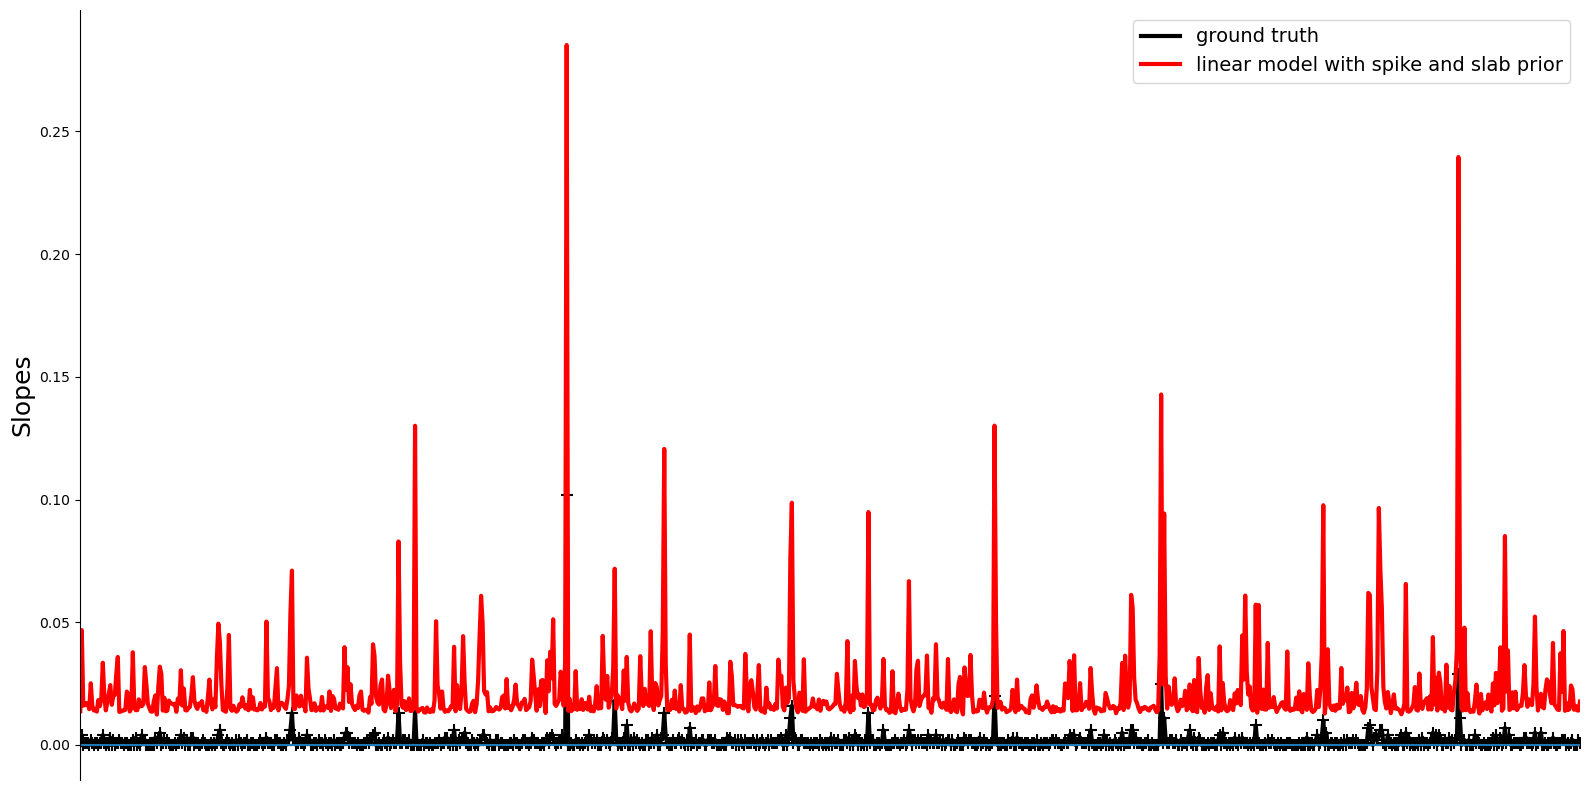

In [129]:
comparison_plot(pi_VI, pi_mcmc)

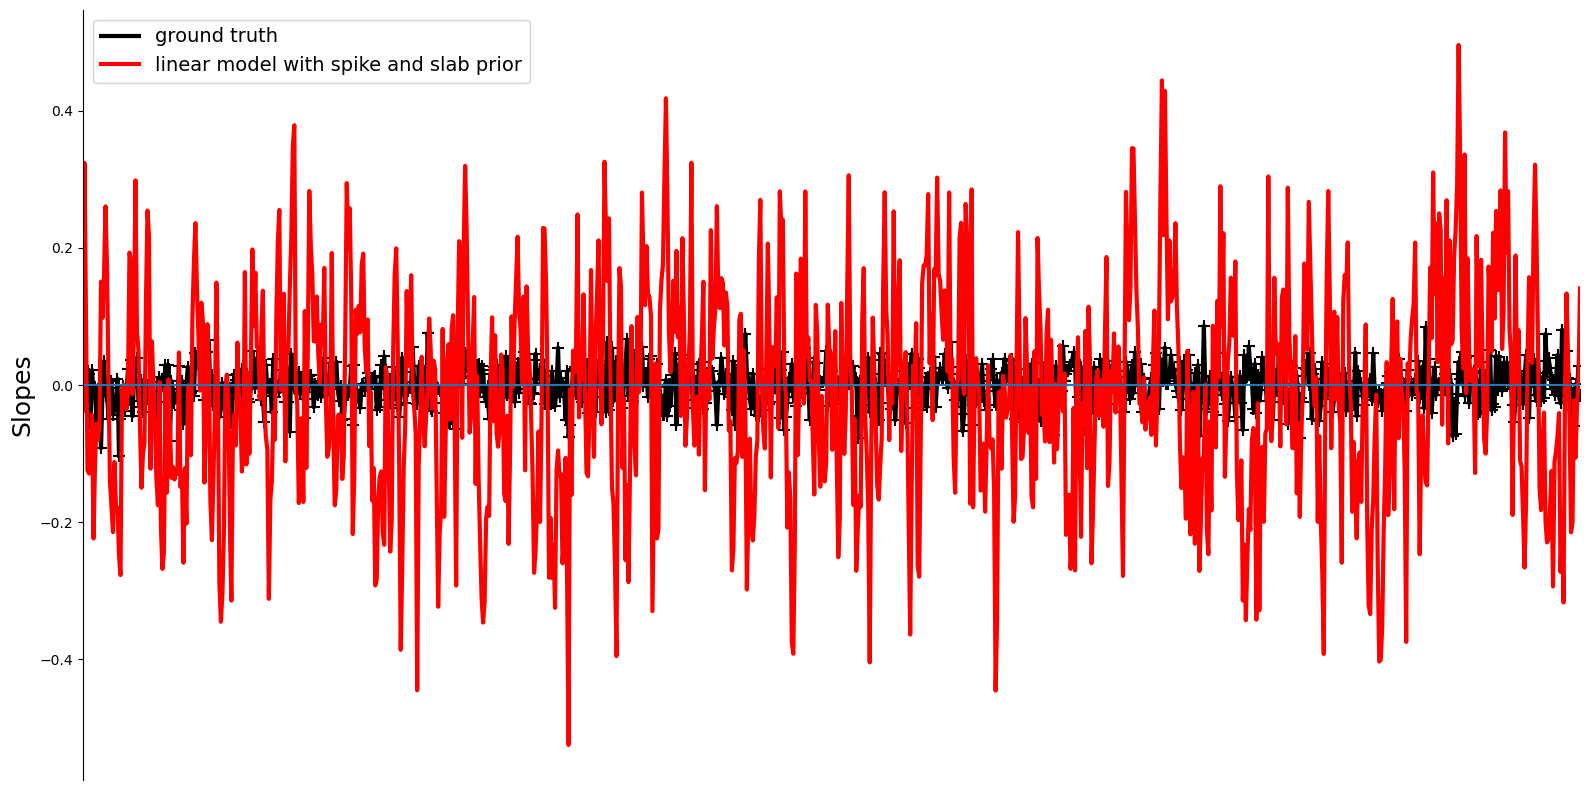

In [130]:
comparison_plot(beta_VI, beta_mcmc)

# Pyro model

5015886.177470088
294986.12266397476
34760.53870844841
5967.491874933243
2175.288955807686
1928.7404998540878
1891.9158798456192
1795.9679560661316
1920.365257024765
1800.7693028450012
1837.2638572454453
2149.3055263757706
1802.094344496727
1799.5246891975403
1882.834886789322
1630.853642463684
1709.3197956085205
1560.864507317543
1622.7481116056442
1450.1525931358337
1372.74464905262
1331.1486947536469
1205.839260816574
1120.0496772527695
1024.5629551410675
943.771008849144
865.234326004982
754.0090763568878
695.1526561379433
614.0721486210823
534.817133128643
450.2483996748924
383.42965841293335
353.77224481105804
325.3021687269211
318.51644146442413
304.104651927948
291.3907631635666
296.7716542482376
292.6289849281311
295.51089602708817
309.3012965917587
300.94209468364716
299.61548709869385
305.316739320755
302.71509861946106
299.5394113063812
314.01801109313965
293.98631250858307
307.3878563642502
278.62937235832214
289.58424985408783
303.60518074035645


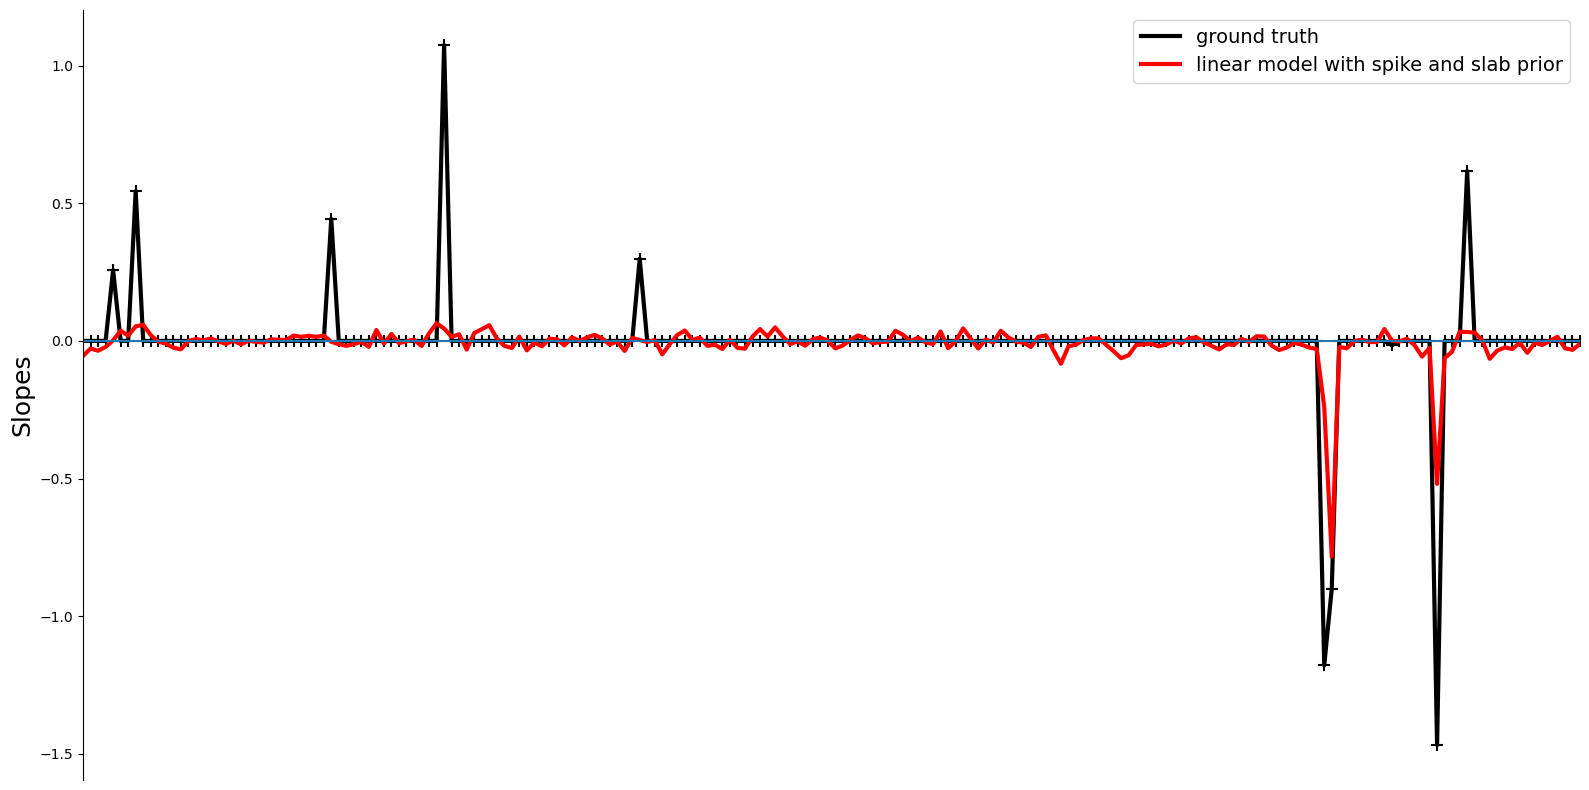

0.35778388


In [24]:
from pyro_model import experiment, get_guide, get_model, spike_slab_model
if device=='cuda':
    use_gpu = True
else:
    use_gpu = False
model = get_model(spike_slab_model, relaxed = True, straight_through =False, temp = 1)
#guide_type: character, 'low_rank_normal', 'diag_normal', 'custom', 'custom_delta'
guide = get_guide(model, guide_type = 'low_rank_normal', relaxed = True, straight_through = False, temp = 1, p = p)
exp = experiment(1e-2, y_star, X, model, guide, mcmc_index = False,
                 schedule_exp = 0.95, n_epoch = 10000, total_patience = 400,num_particles = 1, use_gpu = use_gpu)
exp.init_model()
exp.train(verbose = True)
est, std, lower, upper,parameter_est= exp.cal_heritability(num_samples = 1000)
exp.plot_betas(true_beta)
#print(parameter_est)
#print(true_beta)
print(est)

In [25]:
p

200